In [9]:
import pandas as pd
import numpy as np

# sklearn
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split

# 시각화 라이브러리
import matplotlib.pyplot as plt

# 클러스터 개수 파악
from yellowbrick.cluster import SilhouetteVisualizer

# 텐서플로우
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow import keras

import random

In [10]:
# 데이터프레임이 파라미터
def preprocessing(origin_matrix):
    origin_matrix = origin_matrix.fillna(0)
    data = origin_matrix.values
    train, test = train_test_split(data, test_size=0.3)
    return train, test


class AutoEncoder:
    def __init__(self):
        encoder = 0
        encoder2 = 0
        decoder = 0
        decoder2 = 0
        autoencoder = 0
        history = 0
    
    def make_model(self, train_matrix, units, epochs, lr):
        self.encoder = keras.models.Sequential([keras.layers.Dense(units=6, input_dim=train_matrix.shape[1])])
        self.encoder2 = keras.models.Sequential([keras.layers.Dense(units=units, input_dim=6)])

        self.decoder = keras.models.Sequential([keras.layers.Dense(units=6, input_dim=units)])
        self.decoder2 = keras.models.Sequential([keras.layers.Dense(units=train_matrix.shape[1], input_dim=6)])

        self.autoencoder = keras.models.Sequential([self.encoder, self.encoder2, self.decoder, self.decoder2])

        self.autoencoder.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=lr))
        self.autoencoder.summary()

        self.history = self.autoencoder.fit(train_matrix, train_matrix, epochs=epochs)
        self.encoder.save('encoder_train_1.h5')
        self.decoder.save('decoder_train_1.h5')
    
    def calc_reconstruction_err(self, train_matrix):
        de_pred = self.autoencoder.predict(train_matrix)
        
        # 각 행별 복원 오차
        print('이미지 별 복원오차')
        mse = np.power(de_pred - train_matrix,2).sum(axis=1)/8000
        plt.plot(mse,'o')
        plt.show()
        
        print('최대 복원오차')
        print(mse.max())
        print('최소 복원오차')
        print(mse.min())
        
    def dimension_compression(self, origin_matrix):
        encoded_matrix = self.encoder.predict(origin_matrix)
        #encoded_matrix = self.encoder2.predict(encoded_matrix)
        return encoded_matrix
    
    def retrain(self, extra_matrix, units, epochs, lr, encoder_name, decoder_name):
        new_encoder = tf.keras.models.load_model(encoder_name)
        new_encoder = tf.keras.models.load_model(decoder_name)
        
        self.autoencoder = keras.models.Sequential([self.encoder, self.decoder])
        self.history = self.autoencoder.fit(extra_matrix, extra_matrix, epochs=epochs)
        self.decoder.save('encoder_train_2.h5')
        self.decoder.save('decoder_train_2.h5')


class Cluster:
    def __init__(self):
        model = 0 # 클러스터링을 수행한 모델
        
    def clustring(self, method, matrix, cluster_level, random_state):
        if(method == 'k_medoids'):
            self.model = KMedoids(n_clusters = cluster_level)
        if(method == 'k_means'):
            self.model = KMeans(n_clusters = cluster_level, random_state=random_state)
        if(method == 'dbscan'):
            self.model = DBSCAN(eps=0.5,min_samples=5)
        self.model.fit(matrix)

    def calc_silhouette_coefficient(self, encoded_matrix):
        for i in range(2,19):
            self.clustring('k_medoids', encoded_matrix, i, 21)
            # 실루엣 계수 전체 평균
            average_score = silhouette_score(encoded_matrix, self.model.labels_)
            print('전체 클러스터 실루엣 계수 평균')
            print(average_score)
            
            encoded_matrix_df = pd.DataFrame(encoded_matrix)
            encoded_matrix_df['cluster'] = self.model.labels_

            score_samples = silhouette_samples(encoded_matrix, encoded_matrix_df['cluster'])
            encoded_matrix_df['silhoutte_coeff'] = score_samples
            
            print('클러스터 별 실루엣 계수')
            print(encoded_matrix_df.groupby('cluster')['silhoutte_coeff'].mean())
            print('')
            
            ## 실루엣 계수를 측정해 클러스터링 성능 평가
            print('실루엣 계수 시각화')
            visualizer = SilhouetteVisualizer(self.model, colors='yellowbrick')
            visualizer.fit(encoded_matrix)  
            visualizer.show() 
            
        
    def matrix_to_csv(self, encoded_matrix):
        encoded_matrix_df = pd.DataFrame(encoded_matrix)      

In [11]:
def init_select_img():
    selected_cluster_list = random.sample(range(0,cluster_level), cluster_level)
    selected_img_id_list = []
    for i in range(0,len(selected_cluster_list)):
        print(selected_img_id_list)
        if len(selected_cluster_list) < 5:
            if i == 1 or i == 2:
                selected_img_id_list.extend(clustered_img_id_df[ clustered_img_id_df['cluster'] == selected_cluster_list[i] ].sample(n=2)['id'].values.tolist())
            else:
                selected_img_id_list.extend(clustered_img_id_df[ clustered_img_id_df['cluster'] == selected_cluster_list[i] ].sample(n=1)['id'].values.tolist())
        elif len(selected_cluster_list) < 6:
            if i == 1:
                selected_img_id_list.extend(clustered_img_id_df[ clustered_img_id_df['cluster'] == selected_cluster_list[i] ].sample(n=2)['id'].values.tolist())
            else:
                selected_img_id_list.extend(clustered_img_id_df[ clustered_img_id_df['cluster'] == selected_cluster_list[i] ].sample(n=1)['id'].values.tolist())
        else:
            selected_img_id_list.extend(clustered_img_id_df[ clustered_img_id_df['cluster'] == selected_cluster_list[i] ].sample(n=1)['id'].values.tolist())
    return selected_img_id_list



# 1장, 2장 img가 오면 알맞은 6장 추천
def select_img(img_id_list):
    cluster_list = []
    for i in img_id_list:
        cluster_list.append( clustered_img_id_df.loc[i]['cluster'] ) 
    
    if len(cluster_list) == 1:
        id_list = clustered_img_id_df[clustered_img_id_df['cluster'] == clustered_img_id_df.loc[cluster_list[0]]['cluster']].sample(n=5)['id'].values.tolist()
        id_list.extend( clustered_img_id_df[clustered_img_id_df['cluster'] != clustered_img_id_df.loc[cluster_list[0]]['cluster']].sample(n=1)['id'].values.tolist() )
    elif len(cluster_list) == 2:
        if cluster_list[0] == cluster_list[1]:
            id_list = clustered_img_id_df[clustered_img_id_df['cluster'] == clustered_img_id_df.loc[cluster_list[0]]['cluster']].sample(n=5)['id'].values.tolist()
            id_list.extend( clustered_img_id_df[clustered_img_id_df['cluster'] != clustered_img_id_df.loc[cluster_list[0]]['cluster']].sample(n=1)['id'].values.tolist() )
        else:
            id_list = clustered_img_id_df[clustered_img_id_df['cluster'] == clustered_img_id_df.loc[cluster_list[0]]['cluster']].sample(n=4)['id'].values.tolist()
            id_list.extend( clustered_img_id_df[clustered_img_id_df['cluster'] == clustered_img_id_df.loc[cluster_list[1]]['cluster']].sample(n=1)['id'].values.tolist() )
            clustered_img_id_df.loc[clustered_img_id_df['cluster'].isin(set(clustered_img_id_df['cluster'].unique()) - set([cluster_list[0],cluster_list[1]]))].values.tolist()
    return id_list
    
# 3장 img오면 3장 추천
def recommendation(img_id_list):
    cluster_list = []
    
    for i in img_id_list:
        cluster_list.append( clustered_img_id_df.loc[i]['cluster'] )
    
    if cluster_list[0] == cluster_list[1] and cluster_list[0] == cluster_list[2] and cluster_list[1] == cluster_list[2]:
        print('all')
        recommendation_id_list = clustered_img_id_df[clustered_img_id_df['cluster'] == clustered_img_id_df.loc[cluster_list[0]]['cluster']].sample(n=3)['id'].values.tolist()
    elif cluster_list[0] == cluster_list[1] and cluster_list[0] != cluster_list[2]:
        print(2)
        print(cluster_list)
        recommendation_id_list = clustered_img_id_df[clustered_img_id_df['cluster'] == clustered_img_id_df.loc[cluster_list[0]]['cluster']].sample(n=2)['id'].values.tolist()
        recommendation_id_list.extend( clustered_img_id_df[clustered_img_id_df['cluster'] == clustered_img_id_df.loc[cluster_list[2]]['cluster']].sample(n=1)['id'].values.tolist() )
    elif cluster_list[0] == cluster_list[2] and cluster_list[0] != cluster_list[1]:
        print(3)
        print(cluster_list)
        recommendation_id_list = clustered_img_id_df[clustered_img_id_df['cluster'] == clustered_img_id_df.loc[cluster_list[0]]['cluster']].sample(n=2)['id'].values.tolist()
        recommendation_id_list.extend( clustered_img_id_df[clustered_img_id_df['cluster'] == clustered_img_id_df.loc[cluster_list[1]]['cluster']].sample(n=1)['id'].values.tolist() )
    elif cluster_list[1] == cluster_list[2] and cluster_list[1] != cluster_list[0]:
        print(4)
        print(cluster_list)
        recommendation_id_list = clustered_img_id_df[clustered_img_id_df['cluster'] == clustered_img_id_df.loc[cluster_list[1]]['cluster']].sample(n=2)['id'].values.tolist()
        recommendation_id_list.extend( clustered_img_id_df[clustered_img_id_df['cluster'] == clustered_img_id_df.loc[cluster_list[0]]['cluster']].sample(n=1)['id'].values.tolist() )
    else:
        print(5)
        print(cluster_list)
        recommendation_id_list = clustered_img_id_df[clustered_img_id_df['cluster'] == clustered_img_id_df.loc[cluster_list[0]]['cluster']].sample(n=1)['id'].values.tolist()
        recommendation_id_list.extend( clustered_img_id_df[clustered_img_id_df['cluster'] == clustered_img_id_df.loc[cluster_list[1]]['cluster']].sample(n=1)['id'].values.tolist() )
        recommendation_id_list.extend( clustered_img_id_df[clustered_img_id_df['cluster'] == clustered_img_id_df.loc[cluster_list[2]]['cluster']].sample(n=1)['id'].values.tolist() )
    
    return recommendation_id_list

In [12]:
def make_tag():
    data = pd.read_csv('./predict_list3.csv', encoding='cp949')
    data = data.drop('Name', axis=1)
    data = data.drop('id',axis=1)

    tmp = data['tag1'].str.replace("'", "")
    tmp = tmp.str.replace("(", "")
    tmp = tmp.str.replace(")", "")
    data2 = pd.DataFrame(tmp)

    for i in data.columns[1:]:
        tmp2 = data[i].str.replace("'", "")
        tmp2 = tmp2.str.replace("(", "")
        tmp2 = tmp2.str.replace(")", "")
        data2[i] = tmp2

    tmp2 = data2.loc[0].str.split(', ', expand=True).T
    tmp2.columns = tmp2.loc[0]
    tmp2 = tmp2.drop(0)
    final = tmp2

    for i in range(1,len(data2)):
        tmp2 = data2.loc[i].str.split(', ', expand=True).T
        tmp2.columns = tmp2.loc[0]
        tmp2 = tmp2.drop(0)
        final = pd.concat([final, tmp2])

    final = final.reset_index(drop=True)
    final = final.astype('float')
    return final

<ipython-input-12-41e1d3dcdb02>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tmp = tmp.str.replace("(", "")
<ipython-input-12-41e1d3dcdb02>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tmp = tmp.str.replace(")", "")
<ipython-input-12-41e1d3dcdb02>:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tmp2 = tmp2.str.replace("(", "")
<ipython-input-12-41e1d3dcdb02>:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *n

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 6)                 60        
_________________________________________________________________
sequential_6 (Sequential)    (None, 4)                 28        
_________________________________________________________________
sequential_7 (Sequential)    (None, 6)                 30        
_________________________________________________________________
sequential_8 (Sequential)    (None, 9)                 63        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
197/197 [==============================] - 0s 432us/step - loss: 3.0250e-04
Epoch 2/10
197/197 [==============================] - 0s 416us/step - loss: 8.5582e-06
Epoch 3/10
197/197 [==============================] - 0s 426us/step - loss: 4.98

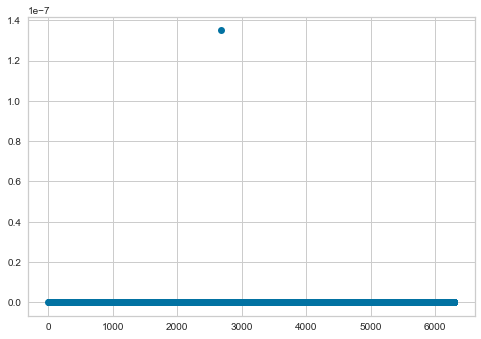

최대 복원오차
1.3499855078780974e-07
최소 복원오차
1.2958135721210995e-13


C:\Users\dundo\anaconda3\envs\py38\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


In [13]:
tag_data = make_tag()
tag_data = tag_data.fillna(0)
tag_data2 = tag_data.astype('float')
train_matrix, test_matrix = preprocessing(tag_data2)

ae = AutoEncoder()
clt = Cluster()
ae.make_model(train_matrix, 4, 10, 0.05)
ae.calc_reconstruction_err(train_matrix)
encoded_matrix = ae.dimension_compression(test_matrix)
clt.clustring('k_medoids', encoded_matrix, 2, 21)

In [14]:
real_data = tag_data2.values
encoded_matrix = ae.dimension_compression(real_data)
clt.clustring('k_medoids', encoded_matrix, 3, 0)

real_data_df = pd.DataFrame(real_data)
real_data_df['cluster'] = clt.model.labels_
real_data_df['id'] = tag_data2.index
matrix_df_csv = real_data_df[['cluster','id']]
matrix_df_csv.to_csv('clustered_img_id.csv',index = False)

clustered_img_id_df = pd.read_csv('clustered_img_id.csv')

C:\Users\dundo\anaconda3\envs\py38\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
C:\Users\dundo\anaconda3\envs\py38\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
